In [49]:
import matplotlib.pyplot as plt
import numpy as np
import os

from ipynb.fs.full.SeedMaskExtractor import find_seed_width_height_area, find_seed_mask
from ipynb.fs.full.SeedFinder import all_seeds

In [50]:
def display_seed(seed, title='seed'):
    plt.imshow(seed, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()

In [51]:
def find_max_width_height_area_of_seeds(seeds_folder):
    max_width, max_height, max_area = 0, 0, 0
    for path in all_seeds:
        seed = np.load(os.path.join(seeds_folder, path))[:,:,200]
        width, height, _, _, area = find_seed_width_height_area(seed)
        max_width = width if width > max_width else max_width
        max_height = height if height > max_height else max_height
        max_area = area if area > max_area else max_area
    return max_width, max_height, area

In [52]:
def create_resized_image(masked_image, max_width, max_height):
    resized_image = np.zeros((max_height + 2, max_width + 2), dtype=np.int64)  # +2 is for all the seeds to be surrounded by black
    height, width = masked_image.shape
    row_offset, column_offset = (max_height - height)//2 + 1, (max_width - width)//2 + 1
    resized_image[row_offset:row_offset + height, column_offset:column_offset + width] = masked_image
    return resized_image

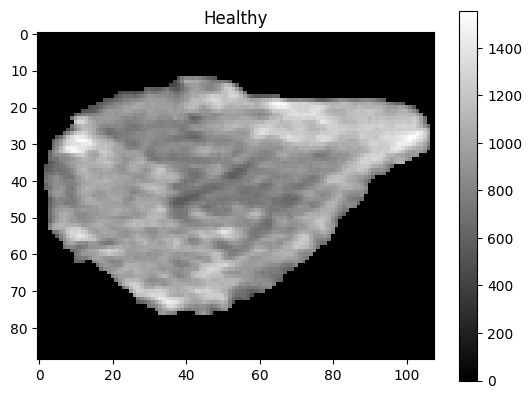

shape before: (76, 114) - shape after: (89, 108)


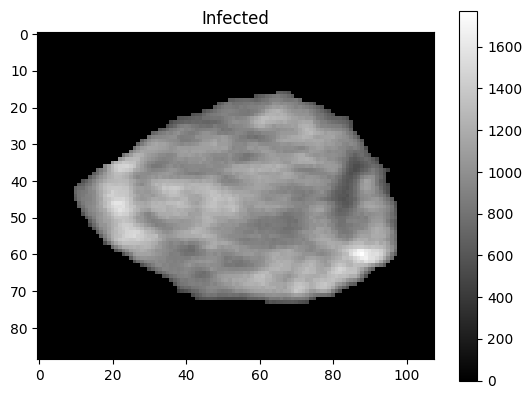

shape before: (69, 98) - shape after: (89, 108)


In [57]:
max_width, max_height, _ = find_max_width_height_area_of_seeds('home')
for path in all_seeds[11:13]:
    seed = np.load(os.path.join('home', path))[:,:,200].squeeze()
    masked_image = find_seed_mask(seed)
    resized_image = create_resized_image(masked_image, max_width, max_height)
    title = 'Healthy' if 'Healthy' in path else 'Infected'
    display_seed(resized_image, title)
    print('shape before:', seed.shape, '- shape after:', resized_image.shape)